# Snow and Stocks  

Does snowfall in New York City affect stock prices ?  This notebook explores that quesiton.  

By Fred Etter - August, 2019

Import modules and libraries:

In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy import stats
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy.stats import ttest_1samp, wilcoxon, ttest_ind, mannwhitneyu
%matplotlib inline

Read in the rain and snow data:

In [2]:
# Use pandas read_csv command to import the local csv file
df = pd.read_csv('snow_and_rain.csv', skiprows=11, sep=';')
df.head()

,Year,Month,Day,Hour,Minute,Total Precipitation (high resolution) daily sum [sfc],Snowfall Amount (high resolution) daily sum [sfc]
0,2009,7,31,0,0,22.7,0.0
1,2009,8,1,0,0,17.4,0.0
2,2009,8,2,0,0,0.0,0.0
3,2009,8,3,0,0,0.2,0.0
4,2009,8,4,0,0,0.0,0.0


Print the columns and then rename them for easier navigation:

In [3]:
print(df.columns)

Index(['Year', 'Month', 'Day', 'Hour', 'Minute',
       'Total Precipitation (high resolution) daily sum [sfc]',
       'Snowfall Amount (high resolution) daily sum [sfc]'],
      dtype='object')


In [4]:
# drop the Hour and Minute columns
df.drop(['Hour', 'Minute'], axis=1, inplace=True)

df.columns = ['Year', 'Month', 'Day', 'Rain', 'Snow']

Display the top 5 columns of the dataframe:

In [5]:
df.head()

,Year,Month,Day,Rain,Snow
0,2009,7,31,22.7,0.0
1,2009,8,1,17.4,0.0
2,2009,8,2,0.0,0.0
3,2009,8,3,0.2,0.0
4,2009,8,4,0.0,0.0


Drop some solumns for plotting purposes and then plot the snow and rain amount in NYC for the past 10 years:

In [6]:
df_plot = df
df_plot['dt'] = pd.to_datetime((df.Year*10000+df.Month*100+df.Day).apply(str),format='%Y%m%d')
df_plot.columns = ['Year', 'Month', 'Day', 'Rain', 'Snow', 'dt']
df_plot.index = pd.to_datetime(df_plot.dt)
df_plot.drop(['Year'], axis=1, inplace=True)
df_plot.drop(['Month'], axis=1, inplace=True)
df_plot.drop(['Day'], axis=1, inplace=True)
df_plot.drop(['dt'], axis=1, inplace=True)

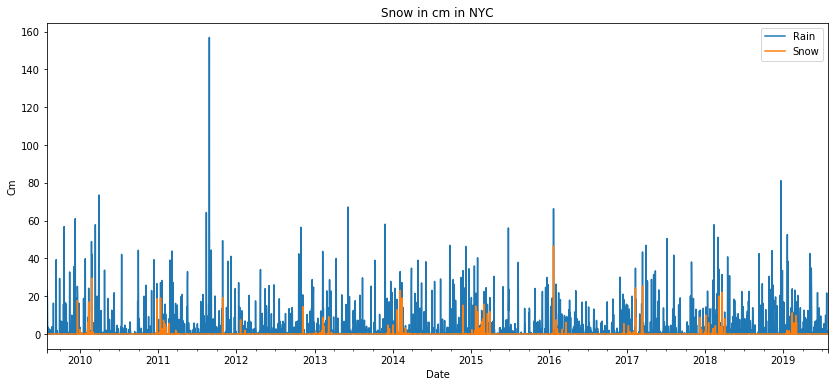

In [7]:
df_plot.plot(figsize=(14, 6))
plt.title('Snow in cm in NYC')
plt.xlabel('Date')
plt.ylabel('Cm')
plt.show()

The plot above shows the daily snow in orange and rain in blue.  Next read in S&P 500 data for the past 10 years approximately:

In [8]:
# read in all of the local csv files into pandas:
df5 = pd.read_csv('SP500_new.csv')

# Convert price to a number, with coersion to throw NA's if conversion not possible
df5['price'] = pd.to_numeric(df5.SP500, errors='coerce')

# Remove NA's
df5.dropna(inplace=True)


In [9]:
df5.head()

,DATE,SP500,price
0,2009-08-07,1010.48,1010.48
1,2009-08-10,1007.10,1007.10
2,2009-08-11,994.35,994.35
3,2009-08-12,1005.81,1005.81
4,2009-08-13,1012.73,1012.73


Plot the S&P 500 index:

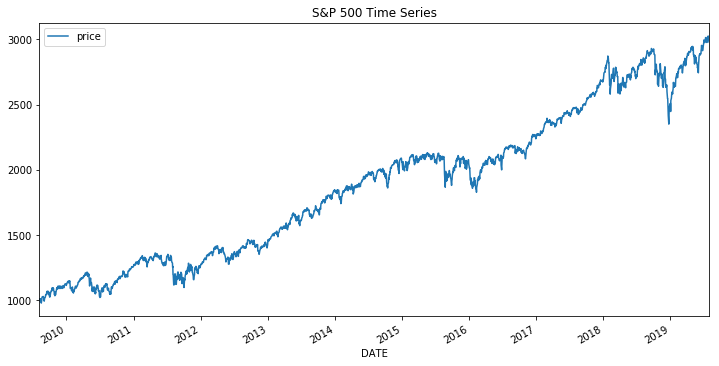

In [10]:
df5.index = pd.to_datetime(df5.DATE)
df5.plot(figsize=(12, 6))
plt.title('S&P 500 Time Series')
plt.show()

The above plot shows the bull market from late 2009 to June of 2019.  Notice that the chart does not have an absolute zero in this case (it is not necessary).  Next, add some columns to perform some analysis:

In [11]:
# For S&P 500
df5['date_time'] = pd.to_datetime(df5['DATE'])

df5['weekday'] = df5.date_time.dt.weekday
df5['day'] = df5.date_time.dt.day
df5['month'] = df5.date_time.dt.month
df5['year'] = df5.date_time.dt.year

Add a column for the change in price for each day:

In [12]:
# add a column for the change in price each day
df5['change'] = df5.price - df5.price.shift()

Sum the total change for each day of the week for the S&P 500 to see the cumulative return for each day:

In [13]:
# For S&P 500
print(df5.loc[df5['weekday'] == 0, 'change'].sum())
print(df5.loc[df5['weekday'] == 1, 'change'].sum())
print(df5.loc[df5['weekday'] == 2, 'change'].sum())
print(df5.loc[df5['weekday'] == 3, 'change'].sum())
print(df5.loc[df5['weekday'] == 4, 'change'].sum())

52.15999999999292
673.5500000000052
574.7199999999998
320.70999999999515
348.76000000000704


The biggest largest difference in the above sums was between Monday and Tuesday.  Monday gained 52 points while Tuesday gained a total of 674 points.  Execute a ttest to determine if the sum of Mondays vs Tuesdays is really significantly different or if the difference was due to random chance:

In [14]:
print(ttest_ind(df5.change.where(df5.weekday == 0).dropna(), df5.change.where(df5.weekday == 1).dropna()))

Ttest_indResult(statistic=-1.1291802920678604, pvalue=0.2590969855069577)


The pvalue above is about 0.26 which is much too high to validate a significant difference between the two days of the week.  It must be assumed that the difference is due to random chance.  If the pvalue was below 0.05, then a real difference can be concluded:

In [15]:
df5.head()

,DATE,SP500,price,date_time,weekday,day,month,year,change
DATE,,,,,,,,,
2009-08-07,2009-08-07,1010.48,1010.48,2009-08-07,4,7,8,2009,NaN
2009-08-10,2009-08-10,1007.10,1007.10,2009-08-10,0,10,8,2009,-3.38
2009-08-11,2009-08-11,994.35,994.35,2009-08-11,1,11,8,2009,-12.75
2009-08-12,2009-08-12,1005.81,1005.81,2009-08-12,2,12,8,2009,11.46
2009-08-13,2009-08-13,1012.73,1012.73,2009-08-13,3,13,8,2009,6.92


Next, print a barplot to show the daily mean of the S&P 500 for each day of the week with a 95% confidence interval to signifiy the possible range of the mean values:

C:\Users\Fred\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


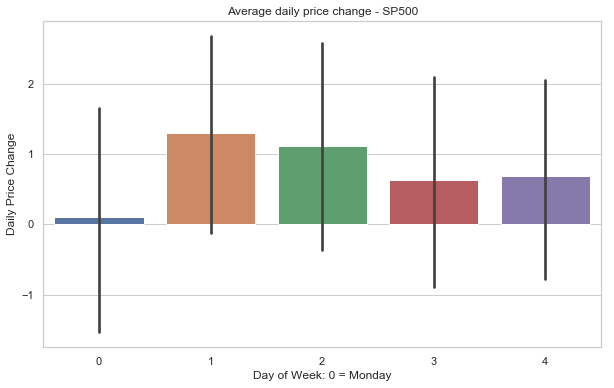

In [16]:
sns.set(style="whitegrid", rc={'figure.figsize':(10, 6)})
sns.barplot(x='weekday', y='change', ci=95, data=df5)
plt.xlabel('Day of Week: 0 = Monday')
plt.ylabel('Daily Price Change')
plt.title('Average daily price change - SP500')
plt.show()

As seen above, the mean values overlap significantly between Monday and Tuesday (as well as every other day).  Next, look at snow data:

In [17]:
df.drop(['Rain'], axis=1, inplace=True)
df.head()

,Snow
dt,
2009-07-31,0.0
2009-08-01,0.0
2009-08-02,0.0
2009-08-03,0.0
2009-08-04,0.0


In [18]:
# reset the index of this dataframe in order to merge this data with another dataframe
df.reset_index(level=0, inplace=True)

In [19]:
# print columns and reset index for S&P 500 data
print(df5.columns)

# Fill Nan values with 0
df5['change'].fillna(0, inplace=True)

# drop unnecessary columns 
df5.drop(['DATE'], axis=1, inplace=True)
df5.drop(['SP500'], axis=1, inplace=True)
df5.drop(['price'], axis=1, inplace=True)
df5.drop(['date_time'], axis=1, inplace=True)
df5.drop(['year'], axis=1, inplace=True)

# reset index for merging data with weather data
df5.reset_index(level=0, inplace=True)

Index(['DATE', 'SP500', 'price', 'date_time', 'weekday', 'day', 'month',
       'year', 'change'],
      dtype='object')


In [20]:
df5.head()

,DATE,weekday,day,month,change
0,2009-08-07,4,7,8,0.00
1,2009-08-10,0,10,8,-3.38
2,2009-08-11,1,11,8,-12.75
3,2009-08-12,2,12,8,11.46
4,2009-08-13,3,13,8,6.92


Merge the snow and S&P 500 data:

In [21]:
# create dataframe for S&P 500 and Snow in NYC in minutes
df_snow = (df.merge(df5, left_on='dt', right_on='DATE')
          .reindex(columns=['DATE', 'weekday', 'day', 'month', 'change', 'Snow']))

Below, see the merged data with the daily change of the S&P 500 and the daily snowfall:

In [22]:
df_snow.head()

,DATE,weekday,day,month,change,Snow
0,2009-08-07,4,7,8,0.00,0.0
1,2009-08-10,0,10,8,-3.38,0.0
2,2009-08-11,1,11,8,-12.75,0.0
3,2009-08-12,2,12,8,11.46,0.0
4,2009-08-13,3,13,8,6.92,0.0


Print the average daily snowfall in NYC in centimeters:

In [23]:
# average snowfall in centimeters:
print(df_snow.Snow.mean())

0.23134554140127384


Execute a ttest to see if there is a significant difference in price change of the S&P 500 for days when there is no snow at all vs days when it snowed at least 0.1 cm:

In [24]:
print(ttest_ind(df_snow.change.where(df_snow.Snow == 0).dropna(), df_snow.change.where(df_snow.Snow > 0.1).dropna()))

Ttest_indResult(statistic=1.2124311083958048, pvalue=0.2254620986994717)


This ttest is showing that there is not a significant difference.  (It is greater than 0.05)  Next, sum up the total price change for days when it did not snow and days where it snowed at least 0.1 cm.  This shows the absolute cumulative change:

In [25]:
# For S&P 500
print(df_snow.loc[df_snow['Snow'] == 0, 'change'].sum())
print(df_snow.loc[df_snow['Snow'] > 0.1, 'change'].sum())


1927.120000000002
-131.58000000000084


Wow, when it does not snow, the S&P 500 gained 1927 points over the past 10 years.  When it snowed at least 0.1 cm, it lost about 132 points.  Seems like snow is not good for stocks, but is this really true ?  See below for further investigation.  The following cell counts the number of days when there was no snow and the number of days where snow was at least 0.1 cm:

In [26]:
print(df_snow.loc[df_snow['Snow'] == 0, 'change'].count())
print(df_snow.loc[df_snow['Snow'] > 0.1, 'change'].count())

2374
125


As shown in the above cell, only 125 data points for when it snows at least 0.1 cm.  This small sample and the difference in sample size could be a problem.  The days whet it snowed at least 0.1 cm only account for about 5% of the days where it did not snow at all.

Next, look at some graphs to back up the insignificance of the pvalue:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


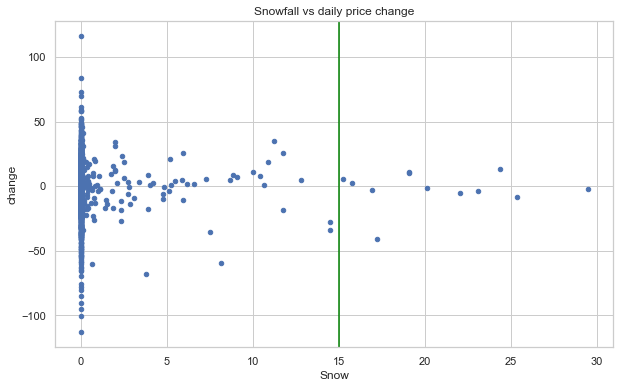

In [27]:
df_snow.plot(kind='scatter', x='Snow', y='change', title='Snowfall vs daily price change', 
                 figsize=(10, 6), grid=True)
plt.axvline(x=15, color='green')

From the graph above, it does look like when it snows, stocks perform worse.  The only problem is -- there are not very many data points for when it does snow.  Next, print a barplot to show the average daily return for when it does not snow at all vs when it snows at least 0.1cm:

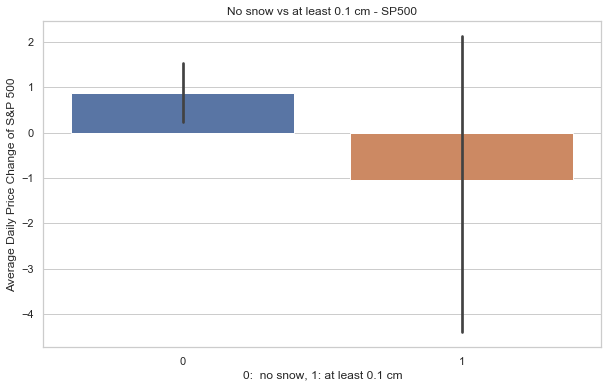

In [28]:
df_snow['amount'] = df_snow['Snow'].apply(lambda x: 1 if x > 0.1 else 0)


sns.set(style="whitegrid", rc={'figure.figsize':(10, 6)})
sns.barplot(x='amount', y='change', ci=95, data=df_snow)
plt.xlabel('0:  no snow, 1: at least 0.1 cm')
plt.ylabel('Average Daily Price Change of S&P 500')
plt.title('No snow vs at least 0.1 cm - SP500')
plt.show()

Even though there is a low enough pvalue; there are not enough samples as evidenced by the mean barplot above with 95% confidence.  There is just too much variance in the possible mean values for when it snows at least 0.1 cm.  The number of days where this occurs from the past 10 years is 125 which was calculated a few cells above.  

The verticle black line above represents the range of the mean value for each dataset with 95% confidence.  There is way too much overlap in the possible mean values for each of the two distributions.  No real conclusion can be drawn for when it doesn't snow at all in NYC vs when it snows at least 0.1 cm.  

As a final test, the next few cells randomly drops 95% of the days where it does not snow at all to obtain approximately the same number of days for when it snows at least 0.1 cm:

In [29]:
df_snow_drop = df_snow.where(df_snow.amount == 0).sample(frac=0.05)

In [30]:
# print days when it doesn't snow (after dropping 95%) and days where it snows at least 0.1 cm:
print(df_snow_drop.loc[df_snow_drop['Snow'] == 0, 'change'].count())
print(df_snow.loc[df_snow['Snow'] > 0.1, 'change'].count())

115
125


In [31]:
# For S&P 500 - print the cumulative return for 5% of days when it didn't snow and the days when it snowed at least 0.1cm:
print(df_snow_drop.loc[df_snow_drop['Snow'] == 0, 'change'].sum())
print(df_snow.loc[df_snow['Snow'] > 0.1, 'change'].sum())

301.3299999999997
-131.58000000000084


Shown above, the return for days of 0 snow is positive 301 points vs negative 132 points on days where it snowed.  Run the ttest for approximately the same sample size for days when it didn't snow vs days where it snowed at least 0.1 cm:

In [32]:
print(ttest_ind(df_snow_drop.Snow.where(df_snow.Snow == 0).dropna(), df_snow.change.where(df_snow.Snow > 0.1).dropna()))

Ttest_indResult(statistic=0.6361253360706519, pvalue=0.5253059869498639)


# Conclusion:  

The pvalue here is 0.52 which is way too high to conclude any significant difference between zero snow days vs at least 0.1 cm days.  

The barplot above further demonstrates the major overlap of the means of the two samples (with the full dataset).  Therefore, it is not possible to conclude that snow affects stock prices.  

Using a different cutoff point for the amount of snowfall (as opposed to 0.1 cm) would probably yield similar results due to the small sample size for days when it does snow.  The difference in the price change summation for the two samples would have to be massive, given the small sample size.  Even though, with all of the data, the difference in price change is 2059 points, this is still not large enough to conclude a true difference in the two different populations.